You are asked to answer each question by completing the code.
*   Please make sure that your code will work fine when the grader executes "Restart and run all"
*   Also make sure that your code won't output anything else but the result asked in the question

You can start with importing some useful libraries:

In [4]:
import numpy as np
import scipy.stats
from matplotlib import pyplot

# 1. Bernoulli MAB

We consider a Bernoulli MAB problem (the arms yield binary rewards), and you are asked to implement MAB algorithms and evaluate their performances via simulation. For this task, you can utilize the following `simulate()` function:

In [5]:
def simulate( K,T, algos, rewards ):
  """
  Input:
    - K: number of arms
    - T: length of time horizon
    - algos: a list of algorithms to simulate
    - rewards: 2-dim np.array representing reward realizations
  Output:
    - actions: 2-dim np.array representing the action sequences selected by algorithms
  """
  assert( rewards.shape == (T,K) )
  actions = np.zeros( (len(algos),T), dtype=np.int32 )

  for i,algo in enumerate(algos):
    algo.reset(K,T)
    for t in range(T):
      a = algo.arm_to_play( t )
      algo.feedback( t, a, rewards[t][a] )
      actions[i][t] = a
  return actions

This `simulate()` function can simulate any MAB algorithm object that implements `reset()`, `feedback()`, and `arm_to_play()` methods. As an example, the following provides an implementation of $\epsilon$-greedy algorithm. The variable `epsilon` indicates the probability of random exploration.

In [6]:
class eGreedy:
  def __init__(self, epsilon):
    self.epsilon = epsilon

  def label(self):
    return r"eGreedy($\epsilon=%.2f$)" % self.epsilon

  def reset(self, K,T):
    self.K, self.T = K, T
    self.selection_counts = np.zeros( self.K, dtype=np.int32 )
    self.cumulative_rewards = np.zeros( self.K, dtype=np.int32 )

  def feedback(self, t, a, r):
    self.selection_counts[a] += 1
    self.cumulative_rewards[a] += r

  def arm_to_play(self, t):
    if np.random.random() < self.epsilon:
      return np.random.choice( self.K )
    elif 0 in self.selection_counts:
      return np.argmin( self.selection_counts )
    return np.argmax( self.cumulative_rewards / self.selection_counts )

The following code simulates the $\epsilon$-greedy algorithm (with different $\epsilon$ values) for an MAB instance with two arms and ten periods. In this particular instance, arm 1 always yields zero reward and arm 2 always yields one unit of reward.

In [7]:
K, T = 2, 20
algos = [eGreedy(0.1), eGreedy(0.2)]

rewards = np.array( [(0,1)]*T )
actions = simulate( K,T, algos, rewards )
print( "eGreedy(0.1)'s action sequence:", actions[0] )
print( "eGreedy(0.2)'s action sequence:", actions[1] )

eGreedy(0.1)'s action sequence: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
eGreedy(0.2)'s action sequence: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


The following code plots how many times each algorithm has selected arm 1 up to time $t=1,\ldots,T$.

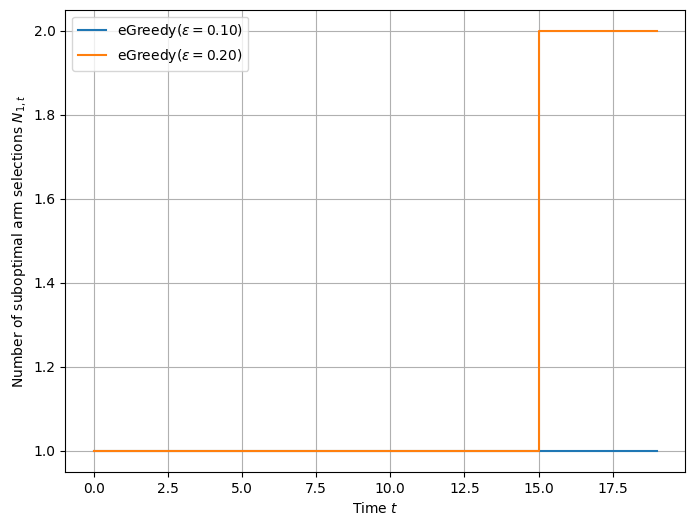

In [8]:
pyplot.figure( figsize=(8,6) )
for i,algo in enumerate(algos):
  pyplot.step( np.arange( len(actions[i]) ), ( actions[i] == 0).cumsum(), label=algo.label() )
pyplot.xlabel( "Time $t$" )
pyplot.ylabel( r"Number of suboptimal arm selections $N_{1,t}$" )
pyplot.grid( True )
pyplot.legend( loc='best' )

#1.1 Upper Confidence Bound Algorithm

**Complete the class `UCB` below that implements UCB algorithm**.
Use the following definition of UCB index:
$$ U_{a,t} := \hat{\mu}_{a,t} + \beta \sqrt{ \frac{ \log(t) }{ N_{a,t} } }, $$
where $\hat{\mu}_{a,t}$ represents the sample mean of arm $a$ at time $t$ and $N_{a,t}$ counts how many times that arm $a$ has been played up to time $t$, and $\beta$ is the control parameter of this UCB algorithm. Just to make sure, UCB algorithm plays $\arg\max_a U_{a,t-1}$ at time $t$.
You can be flexible in the detailed implementation, e.g., how to deal with the case of $N_{a,t}=0$.

In [9]:
import numpy as np

class UCB:
  def __init__(self, beta):
    self.beta = beta

  def label(self):
    return r"UCB($\beta=%.2f$)" % self.beta

  def reset(self, K, T):
    self.K = K
    self.T = T
    self.counts = np.zeros(K, dtype=np.int32)
    self.sum_of_rewards = np.zeros(K, dtype=np.float64)

  def feedback(self, t, a, r):
    self.counts[a] += 1
    self.sum_of_rewards[a] += r

  def arm_to_play(self, t):
    UCB_values = np.zeros(self.K, dtype=np.float64)
    
    for a in range(self.K):
      if self.counts[a] == 0:
        UCB_values[a] = float('inf')
      else:
        mean_est = self.sum_of_rewards[a] / self.counts[a]
        exploration = self.beta * np.sqrt(np.log(t+1) / self.counts[a])
        UCB_values[a] = mean_est + exploration

    return np.argmax(UCB_values)

As done above, you can test your implementation:

In [10]:
K, T = 2, 20
algos = [UCB(0.5)]
rewards = np.array( [(0,1)]*T )
actions = simulate( K,T, algos, rewards )
print( actions )

[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


#1.2 Thompson Sampling Algorithm

**Your task is to implement Thompson sampling algorithm by completing the following code**.
Use Beta(1,1) as a prior for every arm.

In [18]:
import numpy as np

class TS:
  def label(self):
    return r"TS"

  def reset(self, K, T):
    self.K = K
    self.T = T
    self.alpha = np.ones(K, dtype=np.float64)
    self.beta = np.ones(K, dtype=np.float64)

  def feedback(self, t, a, r):
    if r == 1:
      self.alpha[a] += 1
    else:
      self.beta[a] += 1

  def arm_to_play(self, t):
    samples = np.random.beta(self.alpha, self.beta)
    return np.argmax(samples)

As done above, you can test your implementation:

In [19]:
K, T = 2, 20
algos = [TS()]
rewards = np.array( [(0,1)]*T )
actions = simulate( K,T, algos, rewards )
print( actions )

[[0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


#1.3 Regret

Consider an MAB instance with five arms ($K=5$) whose true success probabilities arg given by $\mu=(0.5, 0.4, 0.3, 0.2, 0.1)$, respectively.

We want to evaluate the performance of above MAB algorithms via simulation for this given instance, represented in the form of regret curve: the regret of an algorithm $\pi$ is defined as
$$ \text{Regret}(\pi,T; \mu) := T \max_{a \in \{1,2,3,4,5\}} \mu_a - \mathbb{E}\left[ \sum_{t=1}^T \mu_{A_t^\pi} \right], $$
where $\pi$ is the algorithm to evaluate, $\mu_a$ is the success probability of arm $a$, and $A_t^\pi$ is the arm selected by $\pi$.
Evaluate the regret of eGreedy(0.1), eGreedy(0.2), UCB(0.1), UCB(0.5), UCB(1.0), TS() algorithms for $T=1,2,\ldots,500$ and plot their regret curves. The figure like below is expected.

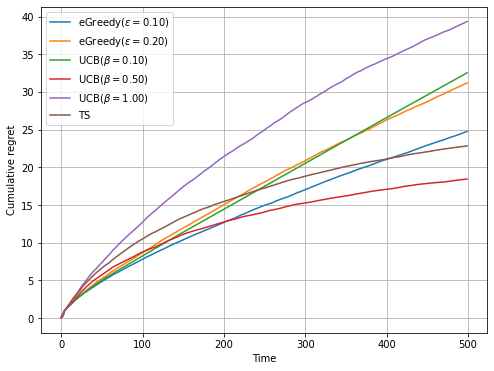

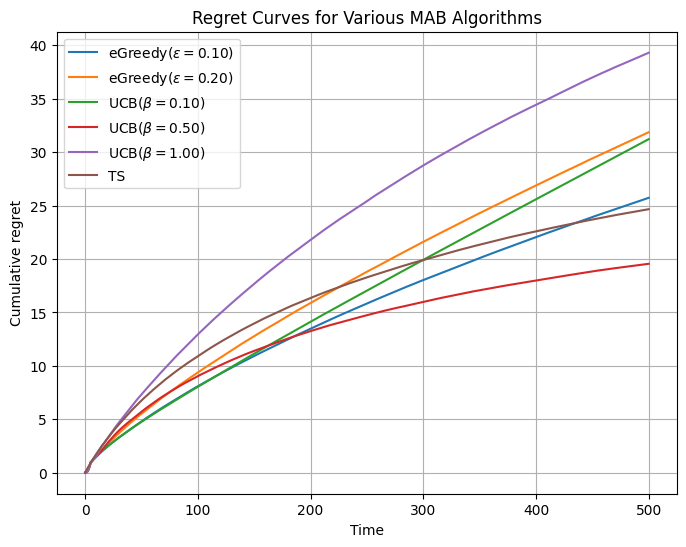

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assume the classes eGreedy, UCB, and TS are already defined as above.
# The arrays and objects 'algos', 'mu', etc. are from the provided code snippet.

K, T_max = 5, 500
mu = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
algos = [
    eGreedy(0.1), 
    eGreedy(0.2), 
    UCB(0.1), 
    UCB(0.5), 
    UCB(1.0), 
    TS()
]

N_sim = 2000  # number of simulations to average over
regret_curves = [np.zeros(T_max+1) for _ in algos]

max_mu = np.max(mu)

for sim in range(N_sim):
    rewards = (np.random.rand(T_max, K) < mu).astype(int)

    actions = simulate(K, T_max, algos, rewards)
    
    for i, algo in enumerate(algos):
        chosen_arm_prob = mu[actions[i]] 
        cumulative_rewards = np.cumsum(chosen_arm_prob)
        simulation_regret = np.zeros(T_max+1)
        simulation_regret[1:] = np.arange(1,T_max+1)*max_mu - cumulative_rewards
        regret_curves[i] += simulation_regret

for i in range(len(algos)):
    regret_curves[i] /= N_sim

plt.figure(figsize=(8,6))
for algo, curve in zip(algos, regret_curves):
    plt.plot(np.arange(T_max+1), curve, label=algo.label())

plt.xlabel("Time")
plt.ylabel("Cumulative regret")
plt.legend(loc='best')
plt.grid(True)
plt.title("Regret Curves for Various MAB Algorithms")
plt.show()

# 2. Multiplie Secretary Problems with Unknown Item Value Distribution

In HW#1, you were asked to solve the multiple secretary problem under the assumption that the item values follow exponential distribution. In this question, you are asked to solve the secretary problem via trial and errors in the absence of knowledge about item value distribution.

Your task is to implement `LearningAgent` class that learns the optimal decision-making strategy through interactions with the unknown environment. It should implement the following member functions that will be called by simulator: `prepare()` in which you have to prepare for a new episode, `action()` in which you have to decide whether select or skip the current item, and `update()` in which you have to update the variables to learn the optimal policy.


In [22]:
import numpy as np

class LearningAgent:
  def __init__(self, num_items, num_choices):
    self.num_items = num_items
    self.num_choices = num_choices
    self.threshold = 0.5
    
    self.alpha = 0.05
    
    self.episode_actions = []
    self.episode_values = []
    self.episode_selected_values = []

  def prepare(self, episode_id):
    self.episode_actions = []
    self.episode_values = []
    self.episode_selected_values = []
    self.selections_left = self.num_choices

  def action(self, episode_id, t, value):
    self.episode_values.append(value)

    if self.selections_left > 0 and value >= self.threshold:
      self.episode_actions.append("select")
      self.episode_selected_values.append(value)
      self.selections_left -= 1
      return "select"
    else:
      self.episode_actions.append("skip")
      return "skip"

  def update(self, episode_id, actions, rewards):

    selected_count = np.sum([1 if a == "select" else 0 for a in actions])
    if selected_count > 0:
      avg_selected_reward = np.mean([r for a, r in zip(actions, rewards) if a == "select"])
    else:
      avg_selected_reward = 0.0

    if selected_count < self.num_choices:
      self.threshold -= self.alpha * (self.threshold - 0.0)
    else:

      if avg_selected_reward < 0.5:
        self.threshold += self.alpha * (1.0 - self.threshold)

    self.threshold = min(max(self.threshold, 0.0), 1.0)

The following code `simulate_multi` function provides a simulated environment that your learning agent will interact with. Any item value distribution can be integrated through the first argument `value_generator`, the function being called to generate the random item values.

In [24]:
def simulate_multi(value_generator, agent, num_items, num_choices, num_episodes):
  results = []

  for episode_id in range(num_episodes):
    agent.prepare( episode_id )         # let the agent prepare for a new episode
    np.random.seed( seed=episode_id )
    item_values = value_generator()     # generate the item values

    remaining_num_choices = num_choices
    actions = []
    rewards = []

    for t,v in enumerate( item_values ):
      action = agent.action( episode_id, t, v ) # retrieve the agent's decision
      assert( action in ("select", "skip") )    # the agent's action must be either "select" or "skip"
      actions.append( action )

      if action == "select":
        rewards.append( v )
        remaining_num_choices -= 1
      else:
        rewards.append( 0 )

      if remaining_num_choices == 0:
        break

    agent.update( episode_id, actions, rewards )    # let the agent update
    results.append( sum(rewards) )

  return results

You can be **totally flexible** in the choice of reinforcement learning algorithm to implement. Just make sure that your algorithm does not explicitly assume specific item value distributions.

Your learning agent will be first evaluated with the following code: your agent is asked to learn the optimal strategy through 50000 episodes where the ground truth item value distribution is given by **exponential distribution** just like HW#1. It will be quite challenging to achieve the theoretically optimal strategy, but you will recieve a full credit as long as your algorithm achieves a performance higher than 90% of the theoretical maximum and the progress in learning can be confirmed from the plot below.

average performance in the last 1000 episodes = 2.864445


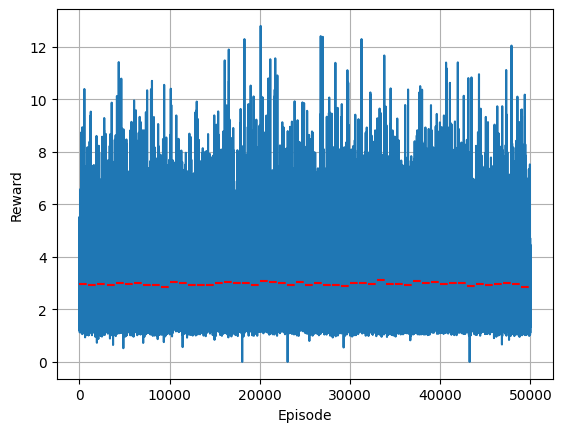

In [25]:
num_items = 10
num_choices = 2
num_episodes = 50000

agent = LearningAgent(num_items, num_choices)
results = simulate_multi( lambda: scipy.stats.expon.rvs( size=num_items ), agent, num_items, num_choices, num_episodes )
print( "average performance in the last 1000 episodes = %f" % np.mean(results[-1000:]) )

pyplot.plot( np.arange(num_episodes), results )
interval = 1000
for t in range(0, num_episodes, interval ):
  pyplot.plot( np.arange(t, t+interval), np.ones(interval) * np.mean(results[t:t+interval]), c='r', ls='--' )
pyplot.xlabel( "Episode" )
pyplot.ylabel( "Reward" )
pyplot.grid( True )

Your learning agent will be evaluated also for the environment where the ground truth item value distribution is given by **uniform distribution**.

average performance in the last 1000 episodes = 2.132101


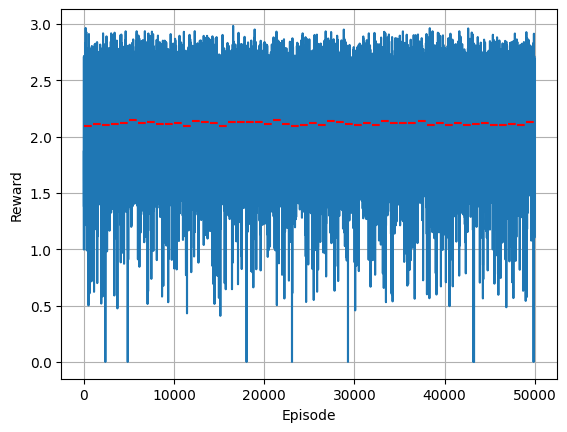

In [26]:
num_items = 10
num_choices = 3
num_episodes = 50000

agent = LearningAgent(num_items, num_choices)
results = simulate_multi( lambda: np.random.random( size=num_items ), agent, num_items, num_choices, num_episodes )
print( "average performance in the last 1000 episodes = %f" % np.mean(results[-1000:]) )

pyplot.plot( np.arange(num_episodes), results )
interval = 1000
for t in range(0, num_episodes, interval ):
  pyplot.plot( np.arange(t, t+interval), np.ones(interval) * np.mean(results[t:t+interval]), c='r', ls='--' )
pyplot.xlabel( "Episode" )
pyplot.ylabel( "Reward" )
pyplot.grid( True )